<a href="https://colab.research.google.com/github/ReemAlsharabi/KAUST-Academy/blob/main/Adv/Day2/MNIST_Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Fine Tuning

In several machine learning applcations, state of the art modles that work on "similar" problems are availabel.

Rather than training a network from scratch, it is worthwhile to use the already available model, albeit they are for a slightly different problem

This is called transfer learning. Possibly the simplest form of transfer learning is Fine-tuning where we make minor adjustments to a network and use it for a new problems.

Fine-tuning is especially effective in cases where limited data is available.

Let's explore example of fine-tunign below. We will fine-tune resent18 trained on imagenet

In [1]:
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchvision.models import resnet18


In [3]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])
    
    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader



In [4]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader=mnist(batch_sz) 

100%|██████████| 9912422/9912422 [00:00<00:00, 103151202.92it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105703048.71it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26114258.84it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21238047.68it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [6]:
net = resnet18(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.4MB/s]


In [29]:
net.fc = nn.Linear(in_features=512, out_features=10, bias=True)
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

net

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 9.0000e-03.
Adjusting learning rate of group 0 to 8.1000e-03.


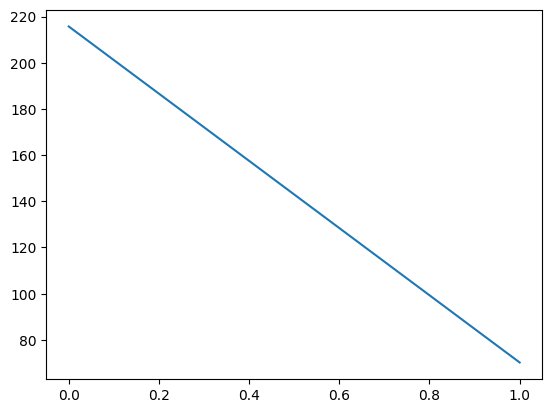

In [9]:
device = torch.device("cuda:0")
num_epochs = 2
lr = 0.01
mm = 0.5

net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = mm)
schduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9, verbose =True)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X,y = batch[0].type(torch.FloatTensor).to(device), batch[1].to(device)
    logits = net(X)
    loss = F.cross_entropy(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()

  schduler.step()
  ls.append(total_loss)


plt.plot(ls)




In [10]:
torch.max(X)

tensor(1., device='cuda:0')

In [11]:
torch.save(net.state_dict(), "myNet.pt")

In [12]:
net2 = resnet18(num_classes = 10)
net2.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


net2.load_state_dict(torch.load("myNet.pt"))

<All keys matched successfully>

In [13]:
print(net.fc.weight)
print(net2.fc.weight)

Parameter containing:
tensor([[ 0.0522,  0.0339,  0.0372,  ..., -0.0516, -0.0006, -0.0477],
        [ 0.0286, -0.0194,  0.0129,  ..., -0.0227, -0.0116, -0.0016],
        [ 0.0008,  0.0422,  0.0614,  ...,  0.0447, -0.0048, -0.0153],
        ...,
        [ 0.0420, -0.0374,  0.0185,  ...,  0.0244,  0.0329,  0.0443],
        [ 0.0229,  0.0135, -0.0243,  ..., -0.0147,  0.0253,  0.0344],
        [-0.0197, -0.0073, -0.0366,  ..., -0.0080, -0.0315, -0.0002]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0522,  0.0339,  0.0372,  ..., -0.0516, -0.0006, -0.0477],
        [ 0.0286, -0.0194,  0.0129,  ..., -0.0227, -0.0116, -0.0016],
        [ 0.0008,  0.0422,  0.0614,  ...,  0.0447, -0.0048, -0.0153],
        ...,
        [ 0.0420, -0.0374,  0.0185,  ...,  0.0244,  0.0329,  0.0443],
        [ 0.0229,  0.0135, -0.0243,  ..., -0.0147,  0.0253,  0.0344],
        [-0.0197, -0.0073, -0.0366,  ..., -0.0080, -0.0315, -0.0002]],
       requires_grad=True)


In [26]:
net = resnet18(pretrained = True)
for params in net.parameters():
  params.requires_grad = False


net.fc = nn.Linear(512,10) # replace the last fully connected layer

In [23]:
for params in net.parameters():
    print(params.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [24]:
# after adjusting the last layer

# unfreeze the network
for params in net.parameters():
  params.requires_grad = True


# fine tune with small learning rate

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 9.0000e-03.
Adjusting learning rate of group 0 to 8.1000e-03.


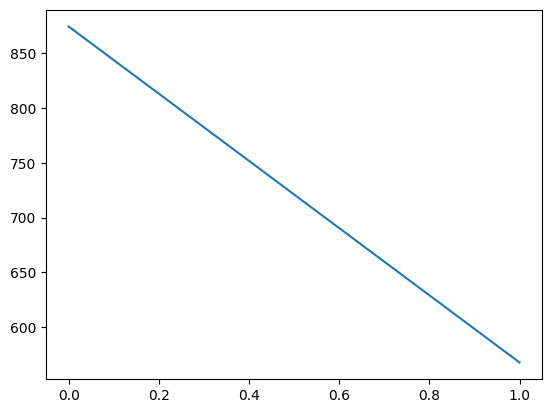

In [30]:
num_epochs = 2
lr = 0.01
mm = 0.5

net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = mm)
schduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9, verbose =True)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X,y = batch[0].type(torch.FloatTensor).to(device), batch[1].to(device)
    logits = net(X)
    loss = F.cross_entropy(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()

  schduler.step()
  ls.append(total_loss)


plt.plot(ls)